Creating Dataset Class and Custom BERT model

In [1]:
import torch
from torch import nn
import numpy as np
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'Financial Crime':0,
          'Cybercrime':1,
          'Drugs and Narcotics Trade':2,
          'Violent Crime':3,
          'Weapons Trade':4
          }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, mode='head'):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [text for text in df['text']]
        self.mode = mode

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        text = self.texts[idx]

        inputs = tokenizer(text, max_length=None, truncation=True, return_tensors="pt")
        return inputs

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        input_ids = batch_texts['input_ids']
        attention_mask = batch_texts['attention_mask']

        if input_ids.shape[1] > 512: #This makes sure the truncation is applied only when the input is longer than 512 tokens
            if self.mode == 'head': #Initial 512 tokens
                input_ids = input_ids[:, :512]
                attention_mask = attention_mask[:, :512]
            elif self.mode == 'tail': #Last 512 tokens
                input_ids = input_ids[:, -512:]
                attention_mask = attention_mask[:, -512:]
            elif self.mode == 'middle':  #Middle 512 tokens --> added latern on for Error Analysis
                center = input_ids.shape[1] // 2
                input_ids = input_ids[:, center - 256:center + 256]
                attention_mask = attention_mask[:, center - 256:center + 256]
            else: #Combined first 256 and last 256
                input_ids = torch.cat((input_ids[:, :256], input_ids[:, -256:]), dim=1)
                attention_mask = torch.cat((attention_mask[:, :256], attention_mask[:, -256:]), dim=1)

        #This adds padding if input is shorter than 512 tokens
        if input_ids.shape[1] < 512:
            padding = torch.zeros(input_ids.shape[0], 512 - input_ids.shape[1])
            input_ids = torch.cat((input_ids, padding), dim=1)
            attention_mask = torch.cat((attention_mask, padding), dim=1)

        return {'input_ids': input_ids, 'attention_mask': attention_mask}, self.get_batch_labels(idx)


class BertClassifier(nn.Module):

    def __init__(model, dropout=0.1):

        super(BertClassifier, model).__init__()

        model.bert = BertModel.from_pretrained('bert-base-uncased')
        model.dropout = nn.Dropout(dropout)
        model.linear = nn.Linear(768, 5)
        model.gelu = nn.GELU()

    def forward(model, input_id, mask):

        _, pooled_output = model.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = model.dropout(pooled_output)
        linear_output = model.linear(dropout_output)
        final_layer = model.gelu(linear_output)

        return final_layer
    
#Part of this code is adapted from https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

Training and evaluating functions

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, f1_score
from torch.optim import AdamW

def train(model, train_data, val_data, learning_rate, epochs, plot_graphs=False, mode='combined', print_epochs=False, early_stop = True):
    train, val = Dataset(train_data, mode=mode), Dataset(val_data, mode=mode)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
    model = model.to(device)  
    if use_cuda and torch.cuda.device_count() > 1:
       model = torch.nn.DataParallel(model, device_ids=[2, 3])  #Wrapping the model to allow for execution on multiple GPUs


    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)


    best_val_balanced_acc = 0
    num_epochs_no_improvement = 0

    train_losses = []
    val_losses = []
    train_balanced_accuracies = []  
    val_balanced_accuracies = []  

    for epoch_num in range(epochs):
        model.train()
        total_loss_train = 0
        y_true, y_pred = [], []

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device, dtype=torch.long)
            input_id = train_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            _, predicted_labels = torch.max(output, dim=1)
            y_true.extend(train_label.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        train_balanced_acc = balanced_accuracy_score(y_true, y_pred)
        train_losses.append(total_loss_train / len(train_data))
        train_balanced_accuracies.append(train_balanced_acc)

        model.eval()
        total_loss_val = 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device, dtype=torch.long)
                input_id = val_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                _, predicted_labels = torch.max(output, dim=1)
                y_true_val.extend(val_label.cpu().numpy())
                y_pred_val.extend(predicted_labels.cpu().numpy())

        val_balanced_acc = balanced_accuracy_score(y_true_val, y_pred_val)
        val_losses.append(total_loss_val / len(val_data))
        val_balanced_accuracies.append(val_balanced_acc)
    
        if print_epochs:
            print(f'Epochs: {epoch_num + 1} | Train Loss: {train_losses[-1]:.3f} '
                  f'| Train Balanced Accuracy: {train_balanced_acc:.3f} '
                  f'| Val Loss: {val_losses[-1]:.3f} '
                  f'| Val Balanced Accuracy: {val_balanced_acc:.3f}')
        
        if val_balanced_acc > best_val_balanced_acc:
            best_val_balanced_acc = val_balanced_acc
            num_epochs_no_improvement = 0
        else:
            num_epochs_no_improvement += 1
        
        if early_stop: #Early stopping if no improvement is observed for 3 consecutive Epochs
            if num_epochs_no_improvement >= 3:
                print(f'Stopping at Epoch {epoch_num + 1}')
                epoch_stop = epoch_num + 1
                return epoch_stop

    if plot_graphs:
        #Loss
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
        plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

        #Balanced Accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_balanced_accuracies, label='Training Balanced Accuracy', color='blue')
        plt.plot(range(1, epochs + 1), val_balanced_accuracies, label='Validation Balanced Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Balanced Accuracy')
        plt.title('Training and Validation Balanced Accuracies')
        plt.legend()
        plt.show()


def evaluate(model, test_data,  mode='combined', metrics=False, save_pred = False):

    test = Dataset(test_data, mode=mode)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
    model = model.to(device)  
    if use_cuda and torch.cuda.device_count() > 1:
       model = torch.nn.DataParallel(model, device_ids=[2, 3])  

    model.eval()
    total_correct_by_class = [0] * len(labels)
    total_samples_by_class = [0] * len(labels)
    all_predictions = []
    all_labels = []
    all_texts = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device, dtype=torch.long)
              input_id = test_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

              output = model(input_id, mask)

              _, predicted_labels = torch.max(output, dim=1)

              all_predictions.extend(predicted_labels.cpu().numpy())
              all_labels.extend(test_label.cpu().numpy())
              

              for i in range(len(test_label)):
                  true_label = test_label[i].item()
                  predicted_label = predicted_labels[i].item()
                  total_samples_by_class[true_label] += 1
                  if true_label == predicted_label:
                      total_correct_by_class[true_label] += 1
    
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    if save_pred:
        output_df = pd.DataFrame({
        'true label': all_labels,
        'predicted label': all_predictions
        })
        output_filename = input("Enter the filename to save predictions (without extension): ")
        output_df.to_csv(f'{output_filename}.csv', index=False)
        
    if metrics:
        print(f'Balanced Accuracy: {balanced_acc:.5f}')

        class_recalls = recall_score(all_labels, all_predictions, labels=range(len(labels)), average=None)

        f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f'F1 Score: {f1:.5f}\n')

        for i, label in enumerate(labels):
            class_recall = class_recalls[i]
            print(f'{label} Recall: {class_recall:.5f}\n')


        #Confusion Matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  
        labels_list = list(labels.keys())
        conf_df = pd.DataFrame(conf_matrix, index=labels_list, columns=labels_list)

        #Heatmap --> percentage of correctedness
        plt.figure(figsize=(10, 7))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(conf_matrix_norm, annot=conf_df, fmt='d', cmap=cmap, cbar_kws={'label': 'Percentage'})
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=45)
        plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)

        plt.show()

    else:
        return balanced_acc #Added for Hyperparameter Tuning (Grid Search based on Balanced Accuracy)

#Part of this code is adapted from https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

Datasets

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("dataset_2.csv", index_col=0) #Preprocessed Dataset path
df.columns


Index(['domain_id', 'page_id', 'snapshot_id', 'tags', 'text', 'text_len',
       'label'],
      dtype='object')

Train test split before lowercasing --> for data augmentation

In [6]:
df_trainval, df_test = train_test_split(df, test_size=0.20, random_state=42, stratify=df[['label']])
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=42, stratify=df_trainval[['label']])

print(df_train.shape, df_trainval.shape, df_val.shape, df_test.shape)

(1282, 7) (1710, 7) (428, 7) (428, 7)


In [7]:
#df_trainval.to_csv('nolower_datasplit/trainval_nolower.csv')
#df_train.to_csv('nolower_datasplit/train_nolower.csv')
#df_val.to_csv('nolower_datasplit/val_nolower.csv')
#df_test.to_csv('nolower_datasplit/test_nolower.csv')
#Save datasets for augmentation

Lowercasing Bert input

In [8]:
df['text'] = df['text'].apply(lambda x: x.lower())

Train/val/test split

In [9]:
df_trainval, df_test = train_test_split(df, test_size=0.20, random_state=42, stratify=df[['label']])
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=42, stratify=df_trainval[['label']])

print(df_train.shape, df_trainval.shape, df_val.shape, df_test.shape)

(1282, 7) (1710, 7) (428, 7) (428, 7)


Hyperparameters tuning

In [11]:
import itertools

def grid_search(param_grid, train_data, val_data):
    best_score = 0
    best_params = {}

    combinations = list(itertools.product(param_grid['lr'], param_grid['dropout'], param_grid['mode']))

    for lr, dropout, mode in combinations:
        model = BertClassifier(dropout=dropout)
        epoch_num = train(model, train_data, val_data, lr, epochs=10, mode=mode, plot_graphs=False)

        with torch.no_grad():
            balanced_acc = evaluate(model, val_data, mode=mode)

        if balanced_acc > best_score:
            best_score = balanced_acc
            if epoch_num:
                best_params = {'lr': lr, 'dropout': dropout, 'epochs' : epoch_num, 'mode': mode}
            else:
                best_params = {'lr': lr, 'dropout': dropout, 'epochs' : 10,  'mode': mode}

    return best_params, best_score


In [12]:
param_grid = {'lr': [5e-5, 4e-5, 3e-5, 2e-5],'dropout': [0.1, 0.3, 0.5], 'mode': ['head', 'tail', 'combined']}

best_params, best_score = grid_search(param_grid, df_train, df_val)

print(f'Best Hyperparameters: {best_params}')
print(f'Best Balanced Accuracy: {best_score:.5f}')

100%|██████████| 81/81 [00:37<00:00,  2.16it/s]


Stopping at Epoch 5


100%|██████████| 81/81 [00:38<00:00,  2.12it/s]


Stopping at Epoch 10


100%|██████████| 81/81 [00:37<00:00,  2.18it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:37<00:00,  2.18it/s]


Stopping at Epoch 10


100%|██████████| 81/81 [00:38<00:00,  2.09it/s]


Stopping at Epoch 9


100%|██████████| 81/81 [00:38<00:00,  2.09it/s]


Stopping at Epoch 8


100%|██████████| 81/81 [00:40<00:00,  2.01it/s]


Stopping at Epoch 7


100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


Stopping at Epoch 7


100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:38<00:00,  2.08it/s]


Stopping at Epoch 5


100%|██████████| 81/81 [00:39<00:00,  2.05it/s]


Stopping at Epoch 8


100%|██████████| 81/81 [00:38<00:00,  2.09it/s]


Stopping at Epoch 8


100%|██████████| 81/81 [00:39<00:00,  2.05it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:38<00:00,  2.11it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:38<00:00,  2.08it/s]


Stopping at Epoch 9


100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


Stopping at Epoch 10


100%|██████████| 81/81 [00:39<00:00,  2.06it/s]


Stopping at Epoch 8


100%|██████████| 81/81 [00:37<00:00,  2.13it/s]


Stopping at Epoch 5


100%|██████████| 81/81 [00:38<00:00,  2.09it/s]


Stopping at Epoch 7


100%|██████████| 81/81 [00:37<00:00,  2.15it/s]


Stopping at Epoch 5


100%|██████████| 81/81 [00:38<00:00,  2.12it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:39<00:00,  2.06it/s]


Stopping at Epoch 7


100%|██████████| 81/81 [00:37<00:00,  2.13it/s]


Stopping at Epoch 7


100%|██████████| 81/81 [00:38<00:00,  2.13it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:37<00:00,  2.17it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:36<00:00,  2.19it/s]


Stopping at Epoch 6


100%|██████████| 81/81 [00:39<00:00,  2.06it/s]


Stopping at Epoch 9


100%|██████████| 81/81 [00:38<00:00,  2.08it/s]


Stopping at Epoch 10


100%|██████████| 81/81 [00:38<00:00,  2.09it/s]


Stopping at Epoch 8


100%|██████████| 81/81 [00:37<00:00,  2.16it/s]


Stopping at Epoch 7


100%|██████████| 81/81 [00:38<00:00,  2.13it/s]


Stopping at Epoch 9


100%|██████████| 81/81 [00:36<00:00,  2.19it/s]


Stopping at Epoch 8
Best Hyperparameters: {'lr': 4e-05, 'dropout': 0.3, 'epochs': 10, 'mode': 'combined'}
Best Balanced Accuracy: 0.89408


Exploration of temperature value with tuned values

In [12]:
df_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,387,387,387,387,387,387
Drugs and Narcotics Trade,304,304,304,304,304,304
Financial Crime,492,492,492,492,492,492
Violent Crime,34,34,34,34,34,34
Weapons Trade,65,65,65,65,65,65


In [13]:
aug_034bit_violent_crime = pd.read_csv('datasets_temp/3/aug_violent_crime_03temp_tot.csv', index_col=0).reset_index(drop=True)
aug_034bit_weapons_trade = pd.read_csv('datasets_temp/3/aug_weapons_trade_03temp_tot.csv', index_col=0).reset_index(drop=True)
aug_034bit_drugs_trade = pd.read_csv('datasets_temp/3/aug_drugs_trade_03temp_tot.csv', index_col=0).reset_index(drop=True)
aug_034bit_cybercrime = pd.read_csv('datasets_temp/3/aug_cybercrime_03temp_tot.csv', index_col=0).reset_index(drop=True)

aug_034bit_violent_crime = aug_034bit_violent_crime[aug_034bit_violent_crime['is synthetic'] == True][['text', 'label']].sample(n=458, random_state=42)
aug_034bit_weapons_trade = aug_034bit_weapons_trade[aug_034bit_weapons_trade['is synthetic'] == True][['text', 'label']].sample(n=427, random_state=42)
aug_034bit_drugs_trade = aug_034bit_drugs_trade[aug_034bit_drugs_trade['is synthetic'] == True][['text', 'label']].sample(n=188, random_state=42)
aug_034bit_cybercrime = aug_034bit_cybercrime[aug_034bit_cybercrime['is synthetic'] == True][['text', 'label']].sample(n=105, random_state=42)

df_aug_temp_3_4bit = pd.concat([ df_train[['text', 'label']], aug_034bit_violent_crime, aug_034bit_weapons_trade, aug_034bit_drugs_trade, aug_034bit_cybercrime], ignore_index=True)
df_aug_temp_3_4bit['text'] = df_aug_temp_3_4bit['text'].apply(lambda x: x.lower())

In [14]:
aug_084bit_violent_crime = pd.read_csv('datasets_temp/8/aug_violent_crime_08temp_tot.csv', index_col=0).reset_index(drop=True)
aug_084bit_weapons_trade = pd.read_csv('datasets_temp/8/aug_weapons_trade_08temp_tot.csv', index_col=0).reset_index(drop=True)
aug_084bit_drugs_trade = pd.read_csv('datasets_temp/8/aug_drugs_trade_08temp_tot.csv', index_col=0).reset_index(drop=True)
aug_084bit_cybercrime = pd.read_csv('datasets_temp/8/aug_cybercrime_08temp_tot.csv', index_col=0).reset_index(drop=True)

aug_084bit_violent_crime = aug_084bit_violent_crime[aug_084bit_violent_crime['is synthetic'] == True][['text', 'label']].sample(n=458, random_state=38)
aug_084bit_weapons_trade = aug_084bit_weapons_trade[aug_084bit_weapons_trade['is synthetic'] == True][['text', 'label']].sample(n=427, random_state=38)
aug_084bit_drugs_trade = aug_084bit_drugs_trade[aug_084bit_drugs_trade['is synthetic'] == True][['text', 'label']].sample(n=188, random_state=38)
aug_084bit_cybercrime = aug_084bit_cybercrime[aug_084bit_cybercrime['is synthetic'] == True][['text', 'label']].sample(n=105, random_state=38)

df_aug_temp_8_4bit= pd.concat([ df_train[['text', 'label']], aug_084bit_violent_crime, aug_084bit_weapons_trade, aug_084bit_drugs_trade, aug_084bit_cybercrime], ignore_index=True)
df_aug_temp_8_4bit['text'] = df_aug_temp_8_4bit['text'].apply(lambda x: x.lower())

Best Hyperparameters: {'lr': 4e-05, 'dropout': 0.3, 'epochs': 10, 'mode': 'combined'}

In [21]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [22]:
train(model, df_aug_temp_3_4bit, df_val, LR, EPOCHS, mode=mode, early_stop=True)

100%|██████████| 154/154 [00:59<00:00,  2.58it/s]


Stopping at Epoch 6


6

Balanced Accuracy: 0.86711
F1 Score: 0.89184

Financial Crime Recall: 0.91463

Cybercrime Recall: 0.85385

Drugs and Narcotics Trade Recall: 0.93069

Violent Crime Recall: 0.81818

Weapons Trade Recall: 0.81818



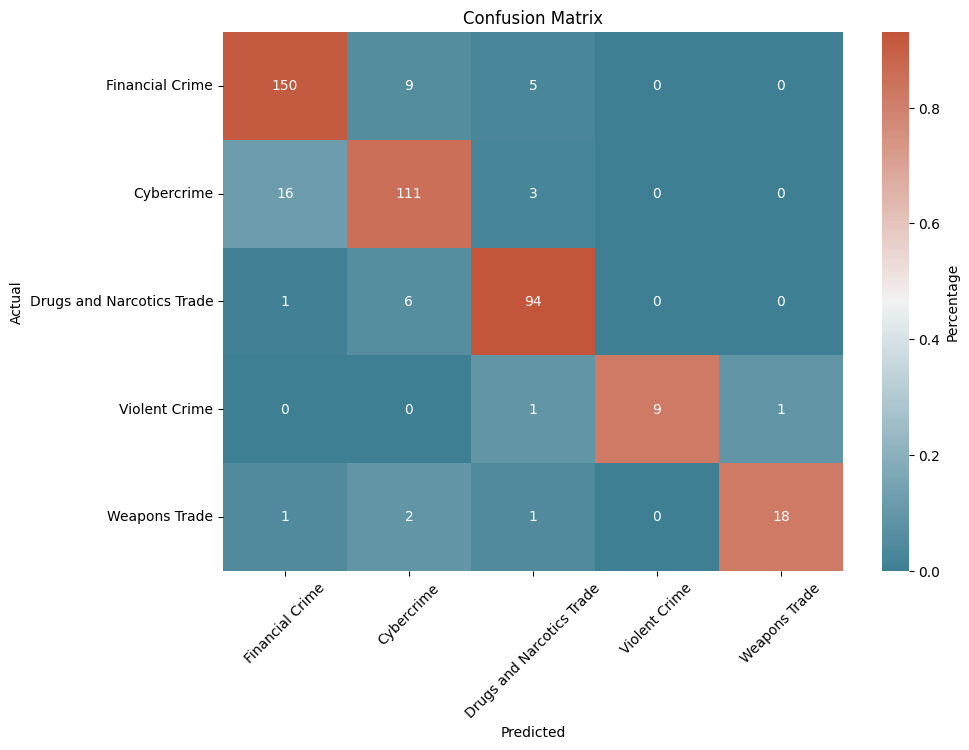

In [23]:
evaluate(model, df_val, mode=mode, metrics=True)

In [24]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [25]:
train(model, df_aug_temp_8_4bit, df_val, LR, EPOCHS, mode=mode, early_stop=True)

100%|██████████| 154/154 [00:59<00:00,  2.60it/s]


Stopping at Epoch 7


7

Balanced Accuracy: 0.87261
F1 Score: 0.85545

Financial Crime Recall: 0.89634

Cybercrime Recall: 0.83846

Drugs and Narcotics Trade Recall: 0.90099

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.81818



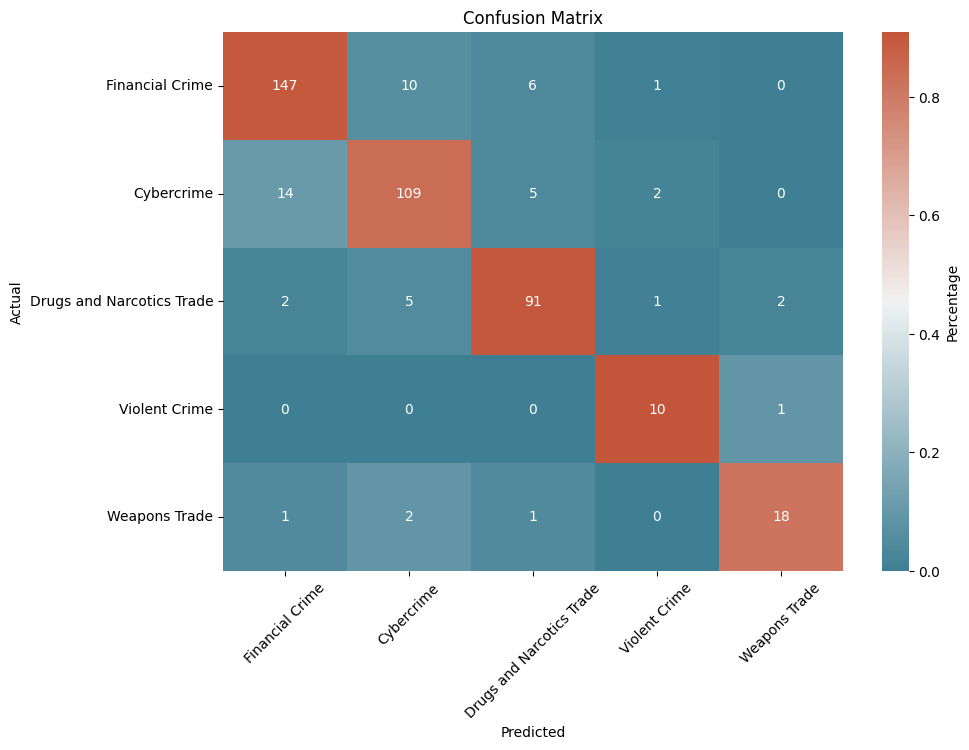

In [25]:
evaluate(model, df_val, mode=mode, metrics=True)

In [26]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [27]:
train(model, df_train, df_val, LR, EPOCHS, mode=mode, early_stop=True)

  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:34<00:00,  2.33it/s]


Stopping at Epoch 9


9

Balanced Accuracy: 0.86335
F1 Score: 0.87566

Financial Crime Recall: 0.88415

Cybercrime Recall: 0.85385

Drugs and Narcotics Trade Recall: 0.85149

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.81818



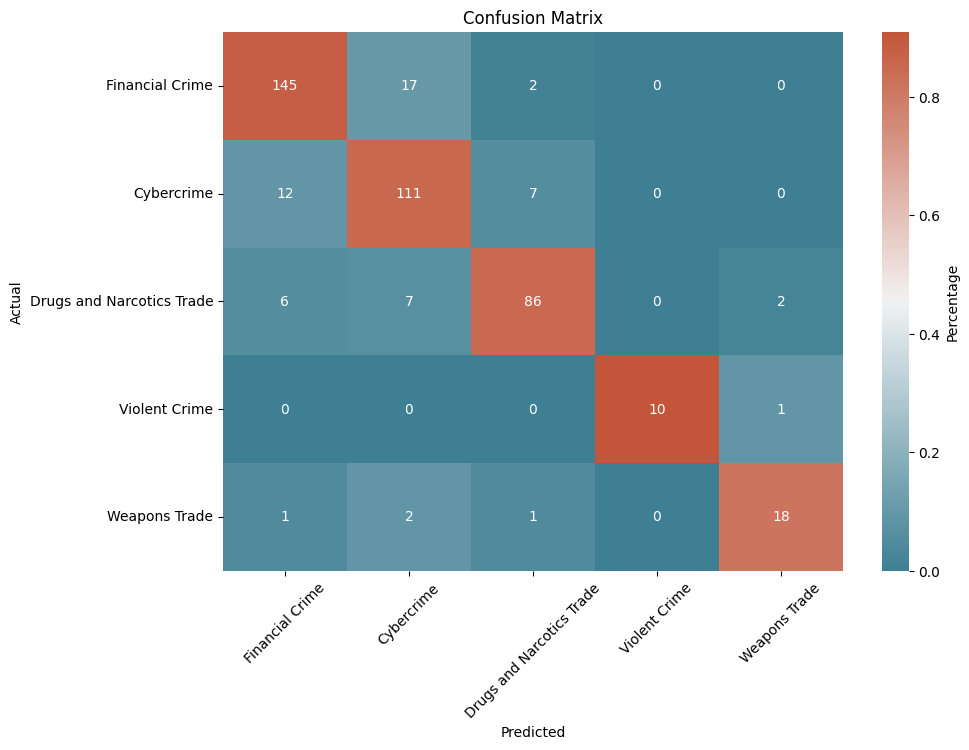

In [28]:
evaluate(model, df_val, mode=mode, metrics=True)

Selected temperature based on Balanced Accuracy = 0.8

LLaMA2 Augmented Dataset

In [29]:
df_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,387,387,387,387,387,387
Drugs and Narcotics Trade,304,304,304,304,304,304
Financial Crime,492,492,492,492,492,492
Violent Crime,34,34,34,34,34,34
Weapons Trade,65,65,65,65,65,65


In [30]:
df_aug_violent_crime_train = pd.read_csv('processed_datasets/aug_violent_crime_train.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_train = pd.read_csv('processed_datasets/aug_cybercrime_train.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_train = pd.read_csv('processed_datasets/aug_weapons_trade_train.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_train = pd.read_csv('processed_datasets/aug_drugs_trade_train.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_train = df_aug_violent_crime_train[['text', 'label']].sample(n=458, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_train = df_aug_cybercrime_train[['text', 'label']].sample(n=105, random_state=42)
df_aug_weapons_trade_train = df_aug_weapons_trade_train[['text', 'label']].sample(n=427, random_state=42)
df_aug_drugs_trade_train = df_aug_drugs_trade_train[['text', 'label']].sample(n=188, random_state=42)

df_aug_train = pd.concat([ df_train[['text', 'label']].copy(), df_aug_cybercrime_train, df_aug_drugs_trade_train, df_aug_violent_crime_train, df_aug_weapons_trade_train], ignore_index=True)
df_aug_train['text'] = df_aug_train['text'].apply(lambda x: x.lower()) 

In [31]:
df_trainval.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,517,517,517,517,517,517
Drugs and Narcotics Trade,405,405,405,405,405,405
Financial Crime,656,656,656,656,656,656
Violent Crime,45,45,45,45,45,45
Weapons Trade,87,87,87,87,87,87


In [32]:
df_aug_violent_crime = pd.read_csv('processed_datasets/aug_violent_crime_pro.csv', index_col=0).reset_index(drop=True)
df_aug_violent_crime = df_aug_violent_crime[['text', 'label']].sample(n=611, random_state=42) #sample needed number to reach majority class volume
df_aug_weapons_trade = pd.read_csv('processed_datasets/aug_weapons_trade_pro.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade = df_aug_weapons_trade[['text', 'label']].sample(n=569, random_state=42)
df_aug_cybercrime = pd.read_csv('processed_datasets/aug_cybercrime_pro.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime = df_aug_cybercrime[['text', 'label']].sample(n=139, random_state=42)
df_aug_drugs_trade = pd.read_csv('processed_datasets/aug_drugs_trade_pro.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade = df_aug_drugs_trade[['text', 'label']].sample(n=251, random_state=42)

In [33]:
df_aug_trainval = pd.concat([ df_trainval[['text', 'label']], df_aug_violent_crime,df_aug_weapons_trade, df_aug_cybercrime, df_aug_drugs_trade], ignore_index=True)

In [34]:
df_aug_train.isna().sum(), df_aug_train.shape

(text     0
 label    0
 dtype: int64,
 (2460, 2))

In [35]:
df_aug_trainval.isna().sum(), df_aug_trainval.shape

(text     0
 label    0
 dtype: int64,
 (3280, 2))

In [36]:
df_aug_train.groupby('label').count()

,text
label,
Cybercrime,492
Drugs and Narcotics Trade,492
Financial Crime,492
Violent Crime,492
Weapons Trade,492


In [37]:
df_aug_trainval.groupby('label').count()

,text
label,
Cybercrime,656
Drugs and Narcotics Trade,656
Financial Crime,656
Violent Crime,656
Weapons Trade,656


Lowercasing Bert input

In [38]:
df_aug_train['text'] = df_aug_train['text'].apply(lambda x: x.lower())
df_aug_trainval['text'] = df_aug_trainval['text'].apply(lambda x: x.lower())

Undersampled dataset

In [39]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy="not minority", random_state=42) 
                     
df_under_train, _ = under.fit_resample(df_train, df_train[["label"]])
df_under_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,34,34,34,34,34,34
Drugs and Narcotics Trade,34,34,34,34,34,34
Financial Crime,34,34,34,34,34,34
Violent Crime,34,34,34,34,34,34
Weapons Trade,34,34,34,34,34,34


In [40]:
df_under_trainval, _ = under.fit_resample(df_trainval, df_trainval[["label"]])
df_under_trainval.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,45,45,45,45,45,45
Drugs and Narcotics Trade,45,45,45,45,45,45
Financial Crime,45,45,45,45,45,45
Violent Crime,45,45,45,45,45,45
Weapons Trade,45,45,45,45,45,45


Comparing the approaches

Epochs and graphs

Baseline

In [41]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

100%|██████████| 81/81 [00:37<00:00,  2.19it/s]


Epochs: 1 | Train Loss: 0.051 | Train Balanced Accuracy: 0.515 | Val Loss: 0.027 | Val Balanced Accuracy: 0.701


100%|██████████| 81/81 [00:34<00:00,  2.32it/s]


Epochs: 2 | Train Loss: 0.022 | Train Balanced Accuracy: 0.724 | Val Loss: 0.023 | Val Balanced Accuracy: 0.845


100%|██████████| 81/81 [00:34<00:00,  2.32it/s]


Epochs: 3 | Train Loss: 0.013 | Train Balanced Accuracy: 0.916 | Val Loss: 0.022 | Val Balanced Accuracy: 0.893


100%|██████████| 81/81 [00:34<00:00,  2.33it/s]


Epochs: 4 | Train Loss: 0.010 | Train Balanced Accuracy: 0.945 | Val Loss: 0.025 | Val Balanced Accuracy: 0.883


100%|██████████| 81/81 [00:34<00:00,  2.33it/s]


Epochs: 5 | Train Loss: 0.007 | Train Balanced Accuracy: 0.967 | Val Loss: 0.025 | Val Balanced Accuracy: 0.884


100%|██████████| 81/81 [00:34<00:00,  2.32it/s]


Epochs: 6 | Train Loss: 0.004 | Train Balanced Accuracy: 0.973 | Val Loss: 0.027 | Val Balanced Accuracy: 0.891


100%|██████████| 81/81 [00:34<00:00,  2.32it/s]


Epochs: 7 | Train Loss: 0.004 | Train Balanced Accuracy: 0.970 | Val Loss: 0.030 | Val Balanced Accuracy: 0.890


100%|██████████| 81/81 [00:34<00:00,  2.33it/s]


Epochs: 8 | Train Loss: 0.003 | Train Balanced Accuracy: 0.984 | Val Loss: 0.030 | Val Balanced Accuracy: 0.883


100%|██████████| 81/81 [00:35<00:00,  2.31it/s]


Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.990 | Val Loss: 0.031 | Val Balanced Accuracy: 0.890


100%|██████████| 81/81 [00:34<00:00,  2.32it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.997 | Val Loss: 0.031 | Val Balanced Accuracy: 0.894


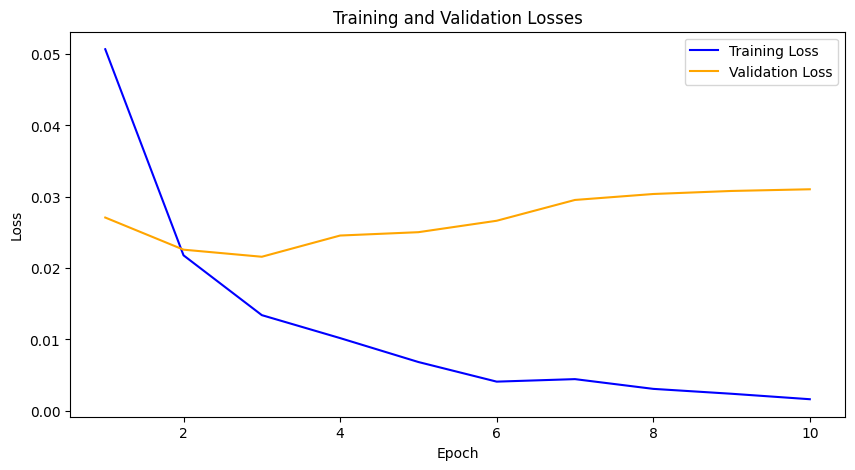

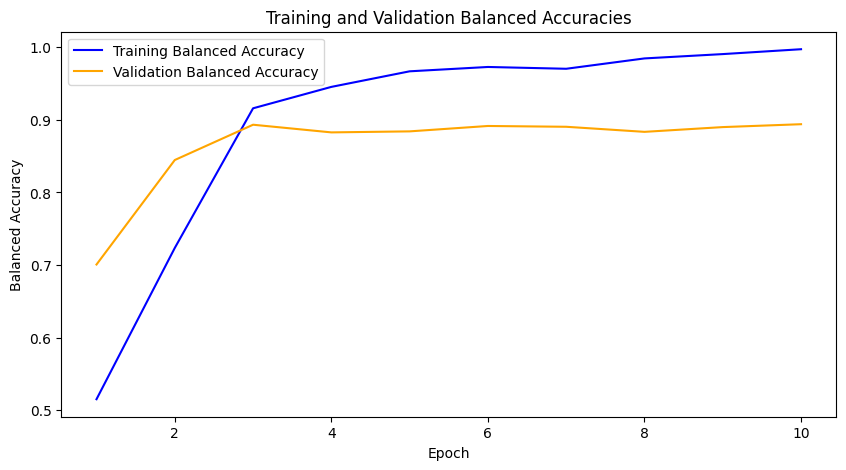

In [58]:
train(model, df_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, print_epochs=True, early_stop=False)

In [42]:
EPOCHS = 3
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [43]:
train(model, df_trainval, df_test, LR, EPOCHS, mode=mode, early_stop=False)

100%|██████████| 107/107 [00:46<00:00,  2.29it/s]


Balanced Accuracy: 0.86637
F1 Score: 0.87584

Financial Crime Recall: 0.89634

Cybercrime Recall: 0.90698

Drugs and Narcotics Trade Recall: 0.89216

Violent Crime Recall: 0.72727

Weapons Trade Recall: 0.90909



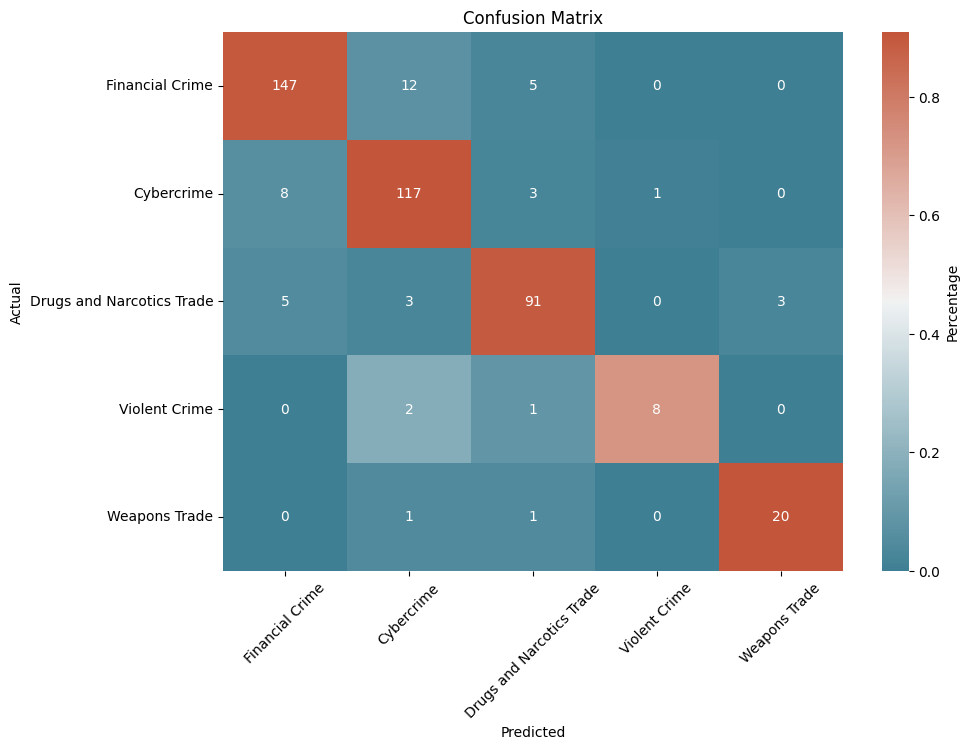

In [61]:
evaluate(model, df_test, mode=mode, metrics=True, save_pred=True)

Balanced Accuracy: 0.85754
F1 Score: 0.86980

Financial Crime Recall: 0.87805

Cybercrime Recall: 0.90698

Drugs and Narcotics Trade Recall: 0.91176

Violent Crime Recall: 0.72727

Weapons Trade Recall: 0.86364



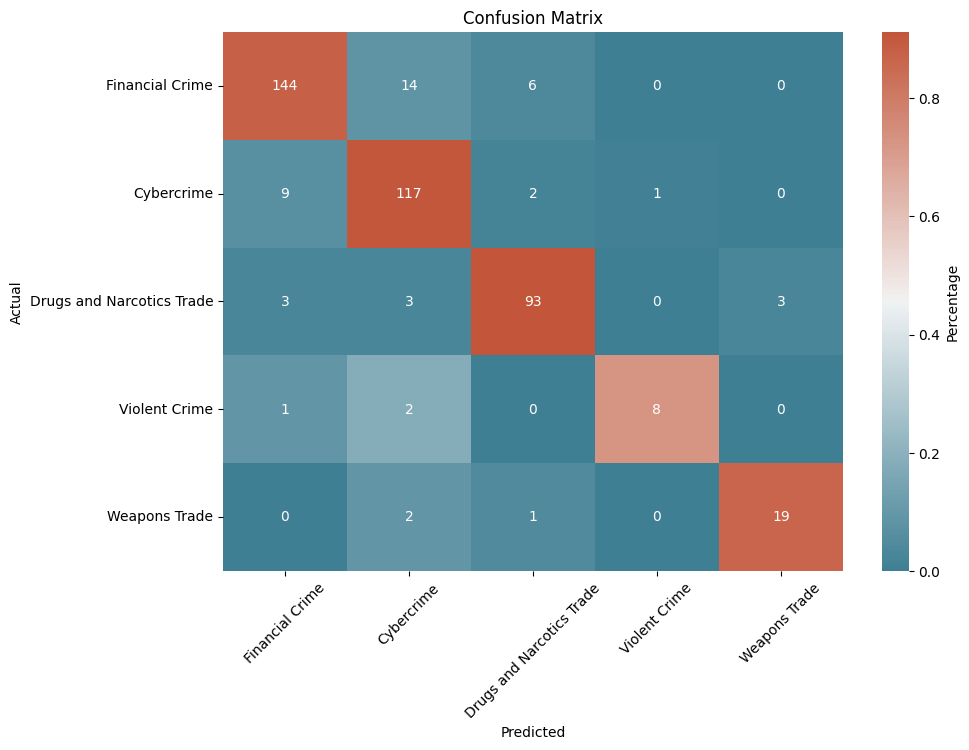

In [44]:
evaluate(model, df_test, mode='middle', metrics=True, save_pred=True) #part of error analysis

Undersampling

In [62]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Epochs: 1 | Train Loss: 0.102 | Train Balanced Accuracy: 0.282 | Val Loss: 0.090 | Val Balanced Accuracy: 0.680


100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


Epochs: 2 | Train Loss: 0.075 | Train Balanced Accuracy: 0.706 | Val Loss: 0.058 | Val Balanced Accuracy: 0.805


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epochs: 3 | Train Loss: 0.044 | Train Balanced Accuracy: 0.894 | Val Loss: 0.046 | Val Balanced Accuracy: 0.798


100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epochs: 4 | Train Loss: 0.027 | Train Balanced Accuracy: 0.924 | Val Loss: 0.041 | Val Balanced Accuracy: 0.821


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Epochs: 5 | Train Loss: 0.017 | Train Balanced Accuracy: 0.947 | Val Loss: 0.037 | Val Balanced Accuracy: 0.829


100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


Epochs: 6 | Train Loss: 0.012 | Train Balanced Accuracy: 0.976 | Val Loss: 0.036 | Val Balanced Accuracy: 0.843


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epochs: 7 | Train Loss: 0.009 | Train Balanced Accuracy: 0.971 | Val Loss: 0.043 | Val Balanced Accuracy: 0.810


100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epochs: 8 | Train Loss: 0.005 | Train Balanced Accuracy: 1.000 | Val Loss: 0.033 | Val Balanced Accuracy: 0.852


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Epochs: 9 | Train Loss: 0.004 | Train Balanced Accuracy: 0.994 | Val Loss: 0.035 | Val Balanced Accuracy: 0.848


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epochs: 10 | Train Loss: 0.003 | Train Balanced Accuracy: 1.000 | Val Loss: 0.040 | Val Balanced Accuracy: 0.833


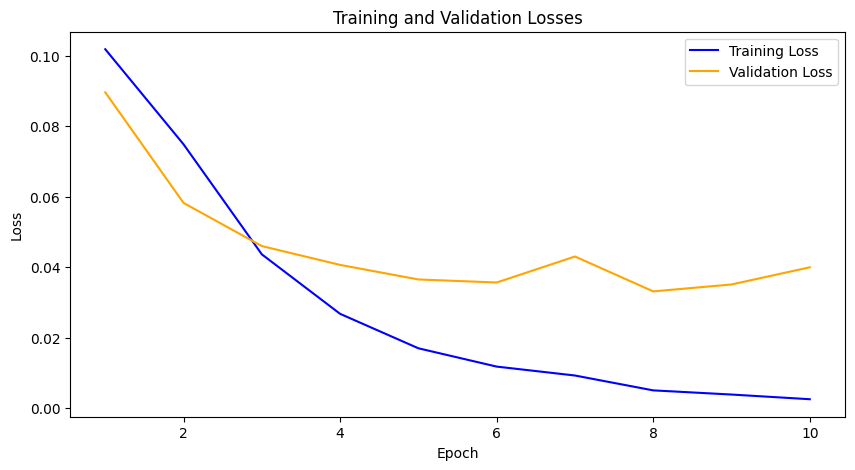

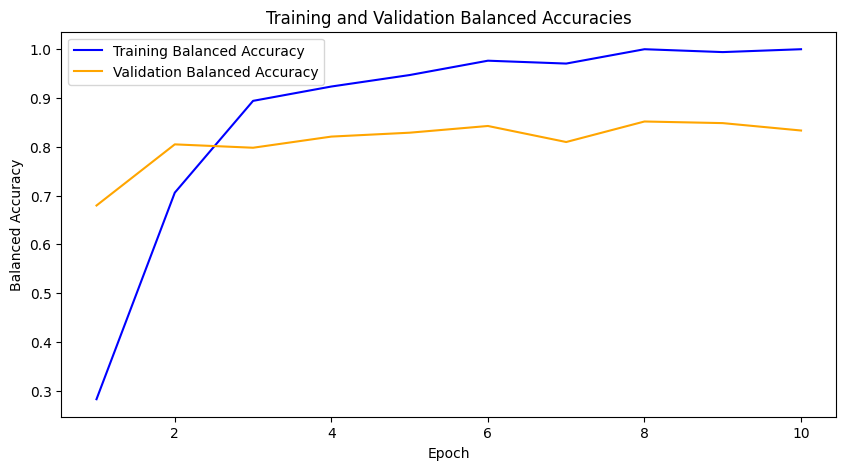

In [63]:
train(model, df_under_train, df_val, LR, EPOCHS,mode=mode, early_stop=False, print_epochs=True, plot_graphs=True)

In [37]:
EPOCHS = 6
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [38]:
train(model, df_under_trainval, df_test, LR, EPOCHS,mode=mode, early_stop=False)

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Balanced Accuracy: 0.88264
F1 Score: 0.85673

Financial Crime Recall: 0.87805

Cybercrime Recall: 0.78295

Drugs and Narcotics Trade Recall: 0.84314

Violent Crime Recall: 1.00000

Weapons Trade Recall: 0.90909



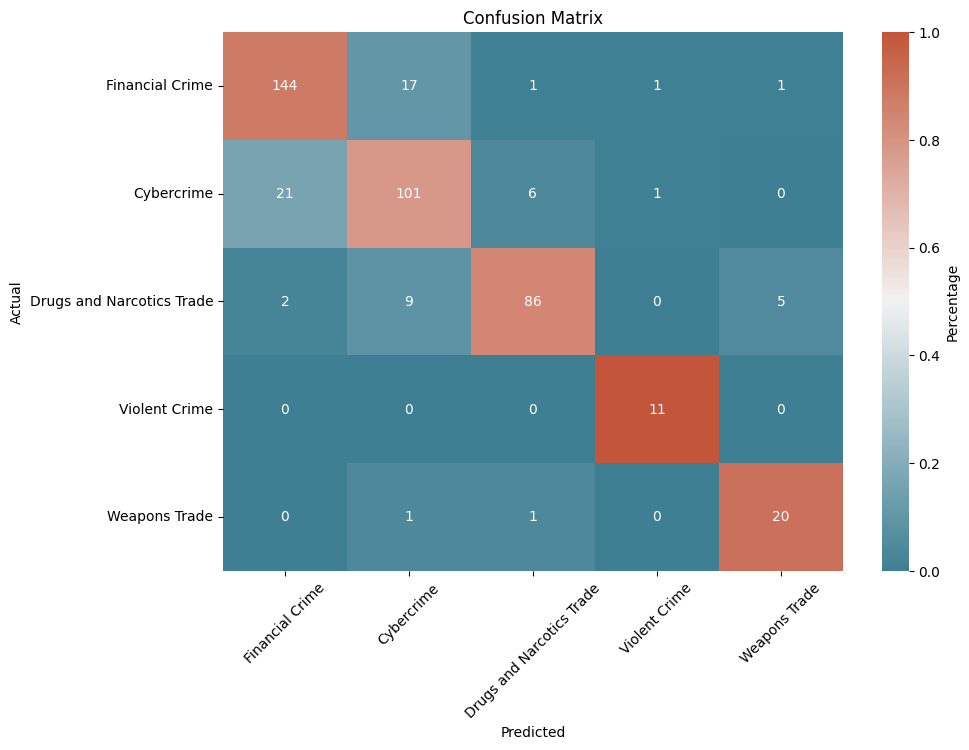

In [39]:
evaluate(model, df_test, mode=mode, metrics=True, save_pred=True)

Augmented Dataset

In [77]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'


  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epochs: 1 | Train Loss: 0.050 | Train Balanced Accuracy: 0.714 | Val Loss: 0.027 | Val Balanced Accuracy: 0.864


100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epochs: 2 | Train Loss: 0.020 | Train Balanced Accuracy: 0.911 | Val Loss: 0.023 | Val Balanced Accuracy: 0.881


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 3 | Train Loss: 0.012 | Train Balanced Accuracy: 0.946 | Val Loss: 0.024 | Val Balanced Accuracy: 0.887


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 4 | Train Loss: 0.007 | Train Balanced Accuracy: 0.970 | Val Loss: 0.033 | Val Balanced Accuracy: 0.841


100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epochs: 5 | Train Loss: 0.005 | Train Balanced Accuracy: 0.976 | Val Loss: 0.026 | Val Balanced Accuracy: 0.888


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 6 | Train Loss: 0.004 | Train Balanced Accuracy: 0.985 | Val Loss: 0.036 | Val Balanced Accuracy: 0.864


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 7 | Train Loss: 0.003 | Train Balanced Accuracy: 0.983 | Val Loss: 0.034 | Val Balanced Accuracy: 0.878


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 8 | Train Loss: 0.003 | Train Balanced Accuracy: 0.989 | Val Loss: 0.031 | Val Balanced Accuracy: 0.886


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.989 | Val Loss: 0.038 | Val Balanced Accuracy: 0.871


100%|██████████| 154/154 [00:58<00:00,  2.63it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.993 | Val Loss: 0.031 | Val Balanced Accuracy: 0.893


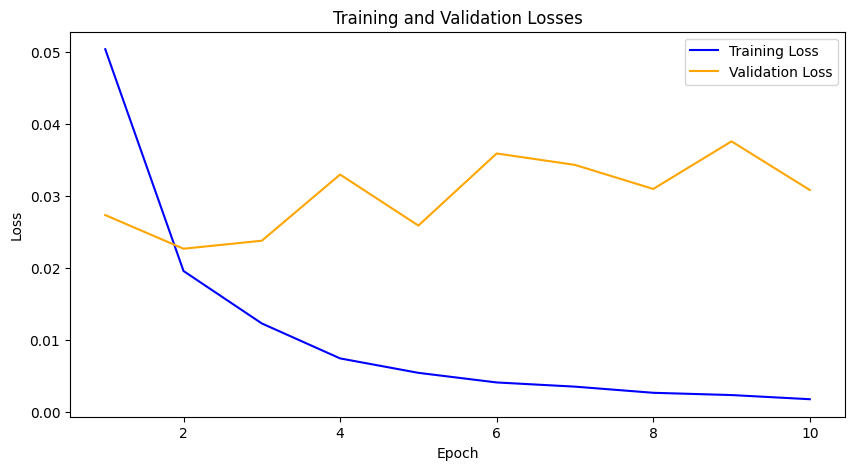

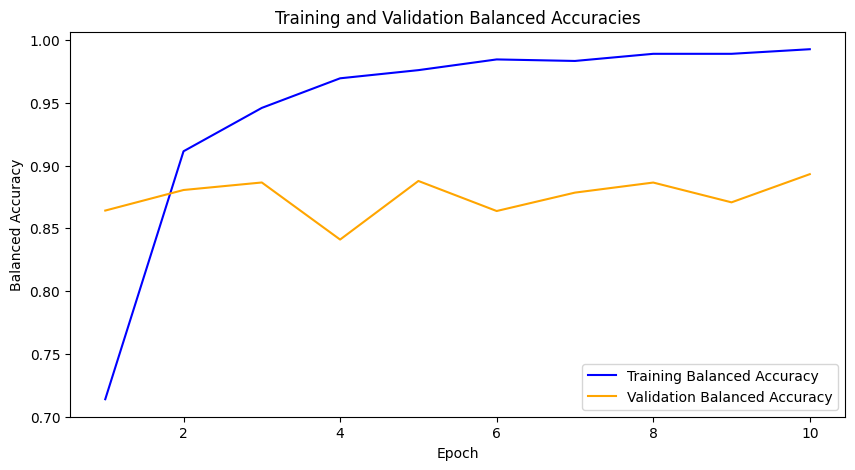

In [78]:
train(model, df_aug_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, early_stop=False, print_epochs=True)

Lower learning rate?

In [42]:
EPOCHS = 20
model = BertClassifier(dropout= 0.3)
LR = 1e-06
mode = 'combined'


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 1 | Train Loss: 0.101 | Train Balanced Accuracy: 0.215 | Val Loss: 0.099 | Val Balanced Accuracy: 0.264


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 2 | Train Loss: 0.097 | Train Balanced Accuracy: 0.352 | Val Loss: 0.093 | Val Balanced Accuracy: 0.338


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 3 | Train Loss: 0.088 | Train Balanced Accuracy: 0.501 | Val Loss: 0.074 | Val Balanced Accuracy: 0.680


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 4 | Train Loss: 0.072 | Train Balanced Accuracy: 0.706 | Val Loss: 0.053 | Val Balanced Accuracy: 0.804


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 5 | Train Loss: 0.056 | Train Balanced Accuracy: 0.796 | Val Loss: 0.041 | Val Balanced Accuracy: 0.840


100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epochs: 6 | Train Loss: 0.046 | Train Balanced Accuracy: 0.841 | Val Loss: 0.035 | Val Balanced Accuracy: 0.847


100%|██████████| 154/154 [00:59<00:00,  2.60it/s]


Epochs: 7 | Train Loss: 0.039 | Train Balanced Accuracy: 0.868 | Val Loss: 0.032 | Val Balanced Accuracy: 0.869


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 8 | Train Loss: 0.035 | Train Balanced Accuracy: 0.877 | Val Loss: 0.029 | Val Balanced Accuracy: 0.873


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 9 | Train Loss: 0.031 | Train Balanced Accuracy: 0.881 | Val Loss: 0.029 | Val Balanced Accuracy: 0.866


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 10 | Train Loss: 0.028 | Train Balanced Accuracy: 0.891 | Val Loss: 0.027 | Val Balanced Accuracy: 0.878


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 11 | Train Loss: 0.026 | Train Balanced Accuracy: 0.901 | Val Loss: 0.026 | Val Balanced Accuracy: 0.874


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 12 | Train Loss: 0.024 | Train Balanced Accuracy: 0.902 | Val Loss: 0.026 | Val Balanced Accuracy: 0.878


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 13 | Train Loss: 0.023 | Train Balanced Accuracy: 0.910 | Val Loss: 0.025 | Val Balanced Accuracy: 0.882


100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epochs: 14 | Train Loss: 0.021 | Train Balanced Accuracy: 0.920 | Val Loss: 0.025 | Val Balanced Accuracy: 0.882


100%|██████████| 154/154 [00:59<00:00,  2.60it/s]


Epochs: 15 | Train Loss: 0.020 | Train Balanced Accuracy: 0.927 | Val Loss: 0.024 | Val Balanced Accuracy: 0.879


100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epochs: 16 | Train Loss: 0.018 | Train Balanced Accuracy: 0.930 | Val Loss: 0.025 | Val Balanced Accuracy: 0.880


100%|██████████| 154/154 [00:58<00:00,  2.62it/s]


Epochs: 17 | Train Loss: 0.017 | Train Balanced Accuracy: 0.937 | Val Loss: 0.024 | Val Balanced Accuracy: 0.883


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 18 | Train Loss: 0.016 | Train Balanced Accuracy: 0.942 | Val Loss: 0.025 | Val Balanced Accuracy: 0.876


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 19 | Train Loss: 0.015 | Train Balanced Accuracy: 0.944 | Val Loss: 0.024 | Val Balanced Accuracy: 0.887


100%|██████████| 154/154 [00:59<00:00,  2.61it/s]


Epochs: 20 | Train Loss: 0.014 | Train Balanced Accuracy: 0.951 | Val Loss: 0.025 | Val Balanced Accuracy: 0.877


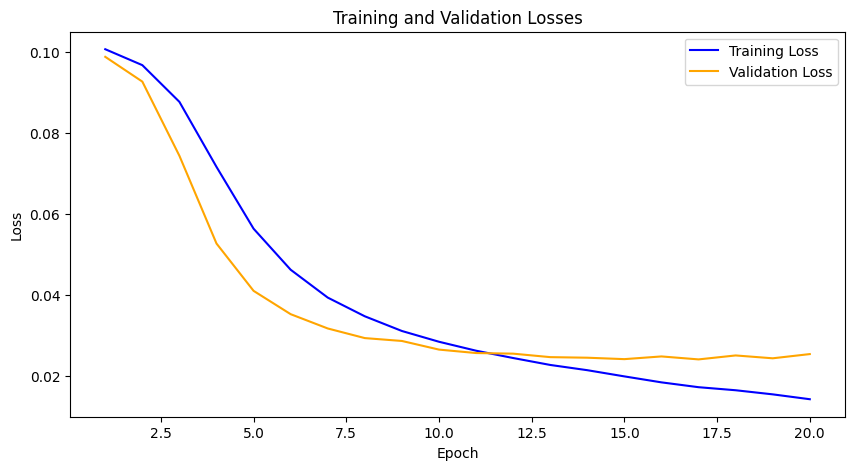

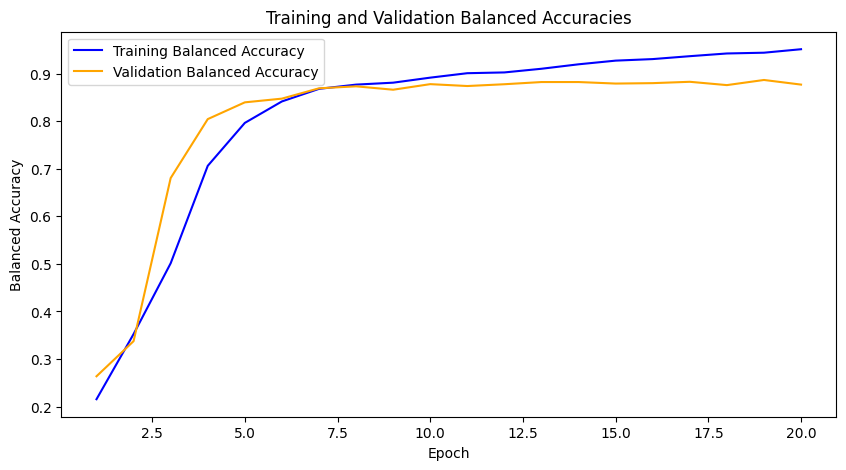

In [43]:
train(model, df_aug_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, early_stop=False, print_epochs=True)

Still does not increase Validation Balanced Accuracy, but smoother --> so probably spikes indicate overfitting after 3 epoch with original LR

In [82]:
EPOCHS = 3
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [83]:
train(model, df_aug_trainval, df_test, LR, EPOCHS, mode=mode, early_stop=False)

100%|██████████| 205/205 [01:25<00:00,  2.41it/s]


Balanced Accuracy: 0.88612
F1 Score: 0.88613

Financial Crime Recall: 0.88415

Cybercrime Recall: 0.86822

Drugs and Narcotics Trade Recall: 0.95098

Violent Crime Recall: 0.81818

Weapons Trade Recall: 0.90909



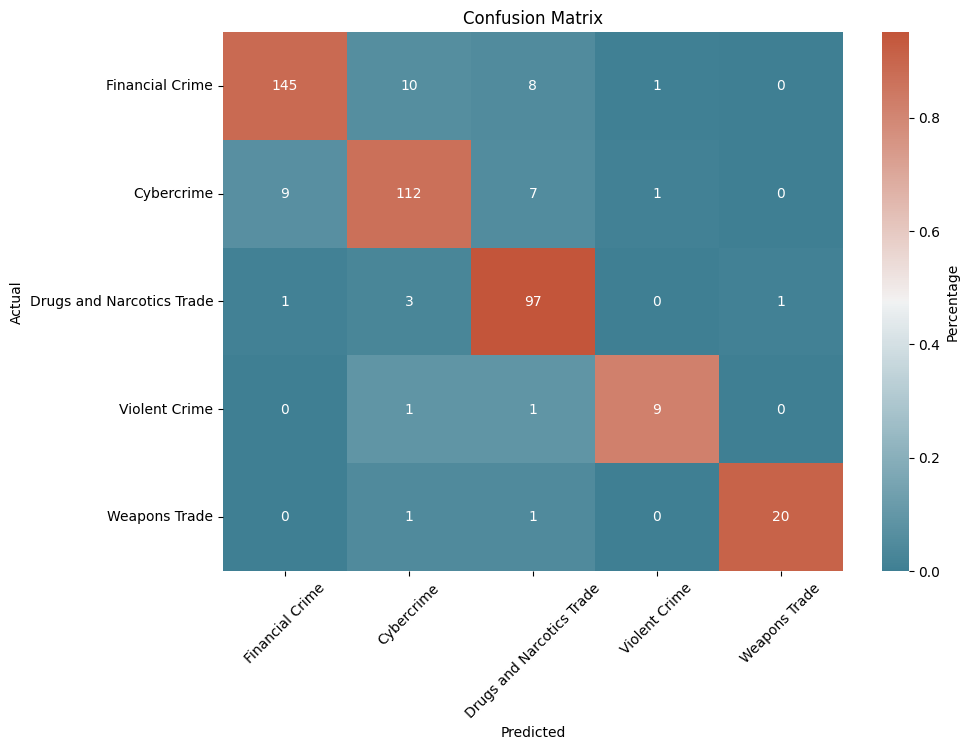

In [85]:
evaluate(model, df_test, mode=mode, metrics=True, save_pred=True)

What if we compare it to the quantized version? for this we use the train augmented set created for the explorative purpose of the temperature value

In [27]:
df_aug_violent_crime_train_quant = pd.read_csv('processed_datasets_08/aug_violent_crime_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_train_quant = pd.read_csv('processed_datasets_08/aug_cybercrime_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_train_quant = pd.read_csv('processed_datasets_08/aug_weapons_trade_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_train_quant = pd.read_csv('processed_datasets_08/aug_drugs_trade_08_pro.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_train_quant = df_aug_violent_crime_train_quant[['text', 'label']].sample(n=458, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_train_quant = df_aug_cybercrime_train_quant[['text', 'label']].sample(n=105, random_state=42)
df_aug_weapons_trade_train_quant = df_aug_weapons_trade_train_quant[['text', 'label']].sample(n=427, random_state=42)
df_aug_drugs_trade_train_quant = df_aug_drugs_trade_train_quant[['text', 'label']].sample(n=188, random_state=42)

df_aug_train_quant = pd.concat([ df_train[['text', 'label']].copy(), df_aug_cybercrime_train_quant, df_aug_drugs_trade_train_quant, df_aug_violent_crime_train_quant, df_aug_weapons_trade_train_quant], ignore_index=True)
df_aug_train_quant['text'] = df_aug_train_quant['text'].apply(lambda x: x.lower())

In [28]:
df_aug_train_quant.groupby('label').count()

,text
label,
Cybercrime,492
Drugs and Narcotics Trade,492
Financial Crime,492
Violent Crime,492
Weapons Trade,492


In [86]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [01:04<00:00,  2.40it/s]


Epochs: 1 | Train Loss: 0.049 | Train Balanced Accuracy: 0.715 | Val Loss: 0.026 | Val Balanced Accuracy: 0.868


100%|██████████| 154/154 [01:04<00:00,  2.40it/s]


Epochs: 2 | Train Loss: 0.020 | Train Balanced Accuracy: 0.910 | Val Loss: 0.026 | Val Balanced Accuracy: 0.865


100%|██████████| 154/154 [01:03<00:00,  2.41it/s]


Epochs: 3 | Train Loss: 0.012 | Train Balanced Accuracy: 0.946 | Val Loss: 0.025 | Val Balanced Accuracy: 0.881


100%|██████████| 154/154 [01:04<00:00,  2.39it/s]


Epochs: 4 | Train Loss: 0.008 | Train Balanced Accuracy: 0.968 | Val Loss: 0.024 | Val Balanced Accuracy: 0.897


100%|██████████| 154/154 [01:04<00:00,  2.39it/s]


Epochs: 5 | Train Loss: 0.005 | Train Balanced Accuracy: 0.981 | Val Loss: 0.037 | Val Balanced Accuracy: 0.846


100%|██████████| 154/154 [01:04<00:00,  2.37it/s]


Epochs: 6 | Train Loss: 0.004 | Train Balanced Accuracy: 0.983 | Val Loss: 0.026 | Val Balanced Accuracy: 0.887


100%|██████████| 154/154 [01:04<00:00,  2.40it/s]


Epochs: 7 | Train Loss: 0.002 | Train Balanced Accuracy: 0.993 | Val Loss: 0.028 | Val Balanced Accuracy: 0.888


100%|██████████| 154/154 [01:04<00:00,  2.38it/s]


Epochs: 8 | Train Loss: 0.002 | Train Balanced Accuracy: 0.995 | Val Loss: 0.032 | Val Balanced Accuracy: 0.877


100%|██████████| 154/154 [01:04<00:00,  2.40it/s]


Epochs: 9 | Train Loss: 0.004 | Train Balanced Accuracy: 0.985 | Val Loss: 0.037 | Val Balanced Accuracy: 0.877


100%|██████████| 154/154 [01:04<00:00,  2.38it/s]


Epochs: 10 | Train Loss: 0.003 | Train Balanced Accuracy: 0.991 | Val Loss: 0.036 | Val Balanced Accuracy: 0.882


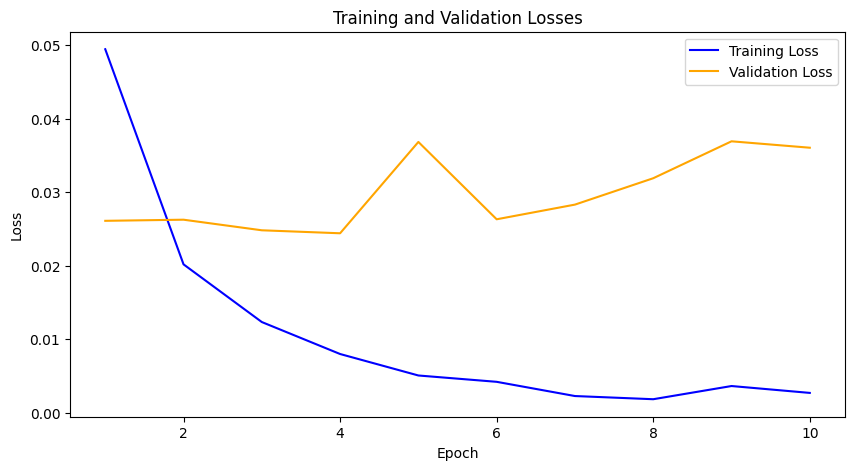

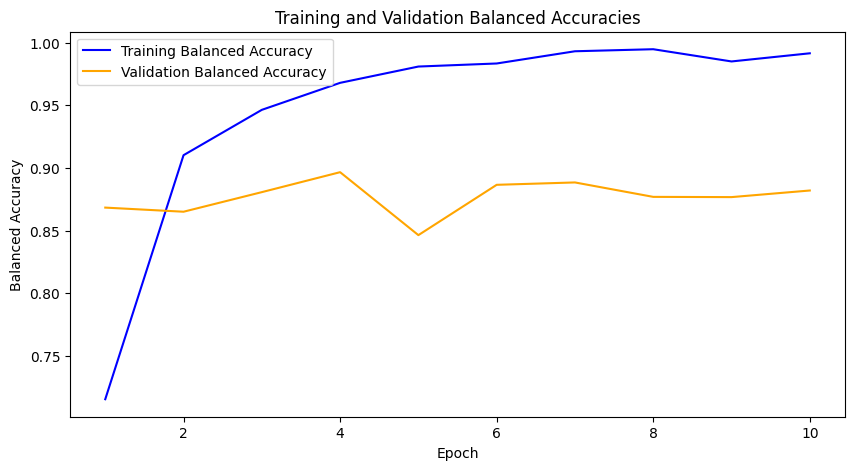

In [87]:
train(model, df_aug_train_quant, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

In [95]:
EPOCHS = 4
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [29]:
df_aug_violent_crime_train_quant2 = pd.read_csv('processed_datasets_08/aug_violent_crime_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_train_quant2 = pd.read_csv('processed_datasets_08/aug_cybercrime_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_train_quant2 = pd.read_csv('processed_datasets_08/aug_weapons_trade_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_train_quant2 = pd.read_csv('processed_datasets_08/aug_drugs_trade_08_pro.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_train_quant2 = df_aug_violent_crime_train_quant2[['text', 'label']].sample(n=611, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_train_quant2 = df_aug_cybercrime_train_quant2[['text', 'label']].sample(n=139, random_state=42)
df_aug_weapons_trade_train_quant2 = df_aug_weapons_trade_train_quant2[['text', 'label']].sample(n=569, random_state=42)
df_aug_drugs_trade_train_quant2 = df_aug_drugs_trade_train_quant2[['text', 'label']].sample(n=251, random_state=42)

df_aug_trainval_quant = pd.concat([ df_trainval[['text', 'label']].copy(), df_aug_cybercrime_train_quant2, df_aug_drugs_trade_train_quant2, df_aug_violent_crime_train_quant2, df_aug_weapons_trade_train_quant2], ignore_index=True)
df_aug_trainval_quant['text'] = df_aug_trainval_quant['text'].apply(lambda x: x.lower())

In [30]:
df_aug_trainval_quant.groupby('label').count() #for this case we sample more examples generated from the train dataset

,text
label,
Cybercrime,656
Drugs and Narcotics Trade,656
Financial Crime,656
Violent Crime,656
Weapons Trade,656


In [98]:
train(model, df_aug_trainval_quant, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/205 [00:00<?, ?it/s]

100%|██████████| 205/205 [01:25<00:00,  2.40it/s]


Balanced Accuracy: 0.90795
F1 Score: 0.89358

Financial Crime Recall: 0.90854

Cybercrime Recall: 0.89147

Drugs and Narcotics Trade Recall: 0.92157

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.90909



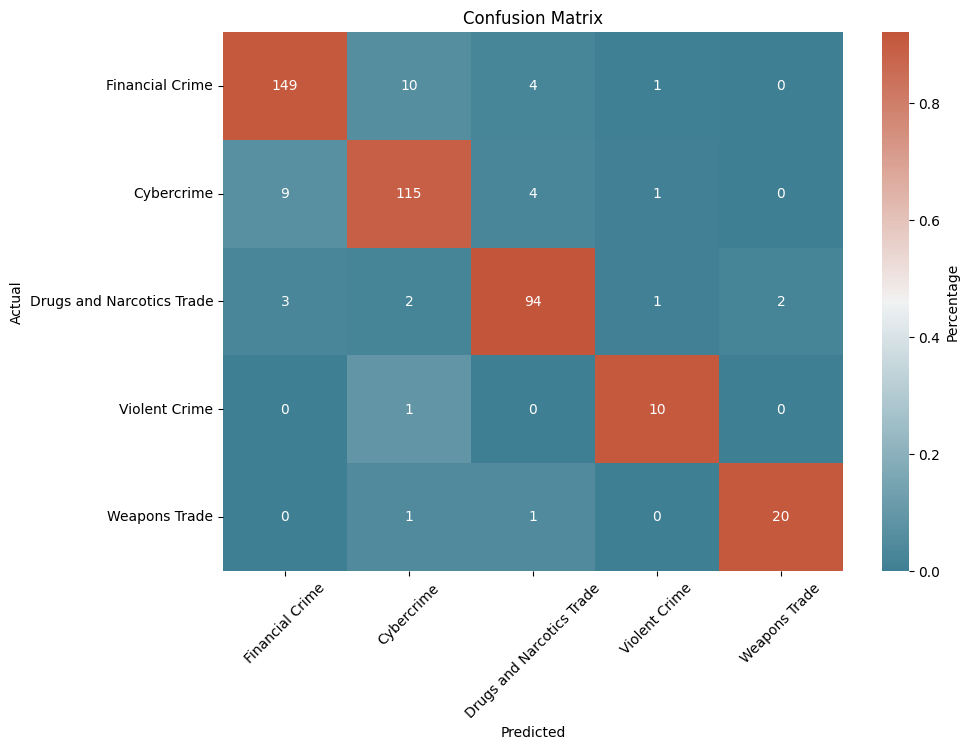

In [99]:
evaluate(model, df_test, mode=mode, metrics=True, save_pred=True)

In [100]:
df_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,387,387,387,387,387,387
Drugs and Narcotics Trade,304,304,304,304,304,304
Financial Crime,492,492,492,492,492,492
Violent Crime,34,34,34,34,34,34
Weapons Trade,65,65,65,65,65,65


Few shot with quantized model

In [112]:
df_aug_violent_crime_train_fs = pd.read_csv('aug_violent_crime_08_train_FS.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_train_fs = pd.read_csv('aug_cybercrime_08_train_FS.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_train_fs = pd.read_csv('aug_weapons_trade_08_train_FS.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_train_fs = pd.read_csv('aug_drugs_trade_08_train_FS.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_train_fs = df_aug_violent_crime_train_fs[['text', 'label']].sample(n=458, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_train_fs = df_aug_cybercrime_train_fs[['text', 'label']].sample(n=105, random_state=42)
df_aug_weapons_trade_train_fs = df_aug_weapons_trade_train_fs[['text', 'label']].sample(n=427, random_state=42)
df_aug_drugs_trade_train_fs = df_aug_drugs_trade_train_fs[['text', 'label']].sample(n=188, random_state=42)

df_aug_train_fs = pd.concat([ df_train[['text', 'label']].copy(), df_aug_cybercrime_train_fs, df_aug_drugs_trade_train_fs, df_aug_violent_crime_train_fs, df_aug_weapons_trade_train_fs], ignore_index=True)
df_aug_train_fs['text'] = df_aug_train_fs['text'].apply(lambda x: x.lower())

In [113]:
df_aug_train_fs.groupby('label').count()

,text
label,
Cybercrime,492
Drugs and Narcotics Trade,492
Financial Crime,492
Violent Crime,492
Weapons Trade,492


In [114]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [01:03<00:00,  2.43it/s]


Epochs: 1 | Train Loss: 0.060 | Train Balanced Accuracy: 0.635 | Val Loss: 0.039 | Val Balanced Accuracy: 0.784


100%|██████████| 154/154 [01:03<00:00,  2.42it/s]


Epochs: 2 | Train Loss: 0.027 | Train Balanced Accuracy: 0.862 | Val Loss: 0.026 | Val Balanced Accuracy: 0.862


100%|██████████| 154/154 [01:04<00:00,  2.40it/s]


Epochs: 3 | Train Loss: 0.016 | Train Balanced Accuracy: 0.916 | Val Loss: 0.026 | Val Balanced Accuracy: 0.881


100%|██████████| 154/154 [01:03<00:00,  2.42it/s]


Epochs: 4 | Train Loss: 0.009 | Train Balanced Accuracy: 0.963 | Val Loss: 0.029 | Val Balanced Accuracy: 0.872


100%|██████████| 154/154 [01:05<00:00,  2.36it/s]


Epochs: 5 | Train Loss: 0.007 | Train Balanced Accuracy: 0.965 | Val Loss: 0.026 | Val Balanced Accuracy: 0.883


100%|██████████| 154/154 [01:04<00:00,  2.40it/s]


Epochs: 6 | Train Loss: 0.004 | Train Balanced Accuracy: 0.985 | Val Loss: 0.033 | Val Balanced Accuracy: 0.867


100%|██████████| 154/154 [01:04<00:00,  2.38it/s]


Epochs: 7 | Train Loss: 0.003 | Train Balanced Accuracy: 0.989 | Val Loss: 0.026 | Val Balanced Accuracy: 0.890


100%|██████████| 154/154 [01:06<00:00,  2.33it/s]


Epochs: 8 | Train Loss: 0.004 | Train Balanced Accuracy: 0.982 | Val Loss: 0.037 | Val Balanced Accuracy: 0.853


100%|██████████| 154/154 [01:04<00:00,  2.39it/s]


Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.989 | Val Loss: 0.041 | Val Balanced Accuracy: 0.857


100%|██████████| 154/154 [01:03<00:00,  2.43it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.990 | Val Loss: 0.038 | Val Balanced Accuracy: 0.867


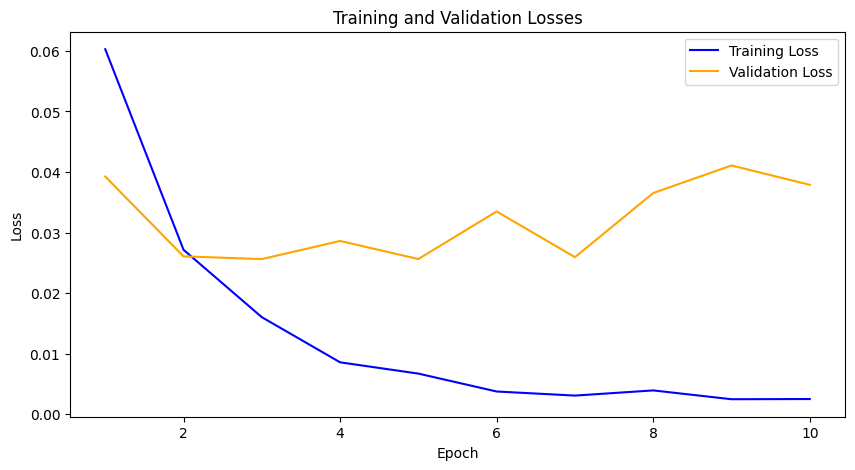

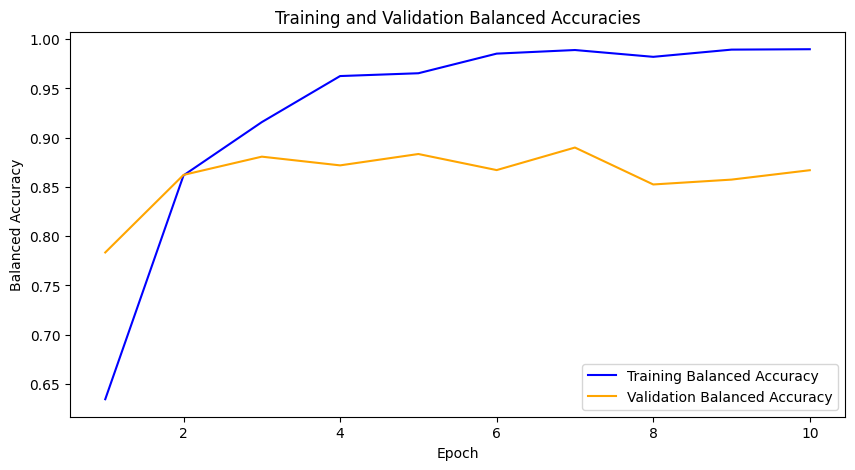

In [115]:
train(model, df_aug_train_fs, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

In [116]:
df_aug_violent_crime_trainval_fs = pd.read_csv('aug_violent_crime_08_trainval_FS.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_trainval_fs = pd.read_csv('aug_cybercrime_08_trainval_FS.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_trainval_fs = pd.read_csv('aug_weapons_trade_08_trainval_FS.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_trainval_fs = pd.read_csv('aug_drugs_trade_08_trainval_FS.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_trainval_fs = df_aug_violent_crime_trainval_fs[['text', 'label']].sample(n=611, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_trainval_fs = df_aug_cybercrime_trainval_fs[['text', 'label']].sample(n=139, random_state=42)
df_aug_weapons_trade_trainval_fs = df_aug_weapons_trade_trainval_fs[['text', 'label']].sample(n=569, random_state=42)
df_aug_drugs_trade_trainval_fs = df_aug_drugs_trade_trainval_fs[['text', 'label']].sample(n=251, random_state=42)

df_aug_trainval_fs = pd.concat([ df_trainval[['text', 'label']].copy(), df_aug_cybercrime_trainval_fs, df_aug_drugs_trade_trainval_fs, df_aug_violent_crime_trainval_fs, df_aug_weapons_trade_trainval_fs], ignore_index=True)
df_aug_trainval_fs['text'] = df_aug_trainval_fs['text'].apply(lambda x: x.lower())

In [117]:
df_aug_trainval_fs.groupby('label').count()

,text
label,
Cybercrime,656
Drugs and Narcotics Trade,656
Financial Crime,656
Violent Crime,656
Weapons Trade,656


In [120]:
EPOCHS = 3
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [121]:
train(model, df_aug_trainval_fs, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/205 [00:00<?, ?it/s]

100%|██████████| 205/205 [01:24<00:00,  2.42it/s]


Balanced Accuracy: 0.90412
F1 Score: 0.88209

Financial Crime Recall: 0.90854

Cybercrime Recall: 0.85271

Drugs and Narcotics Trade Recall: 0.94118

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.90909



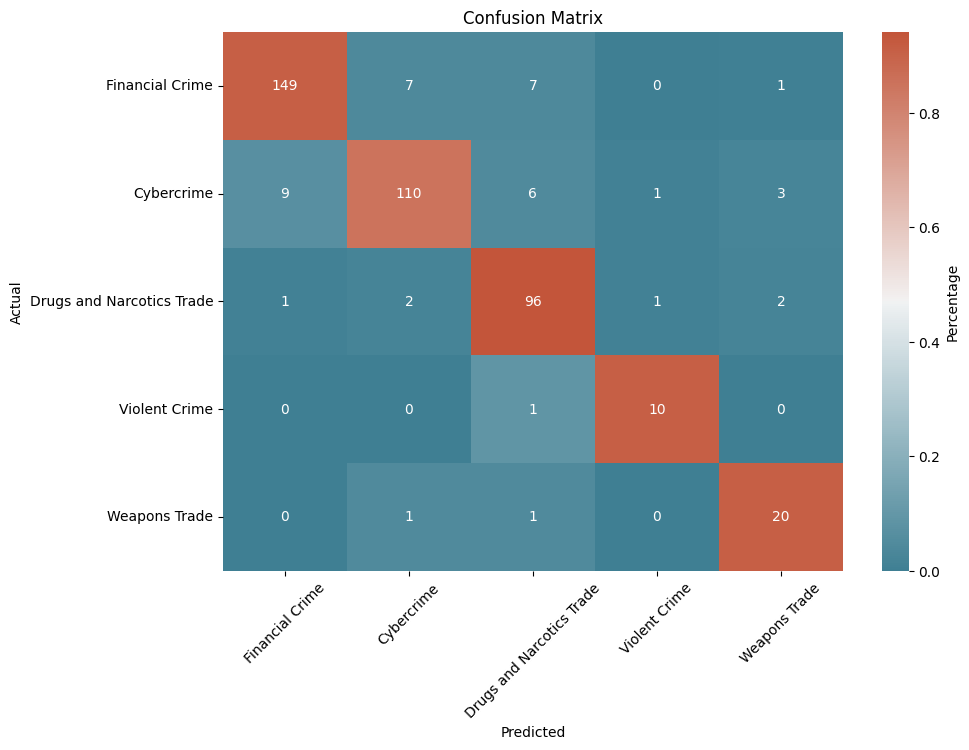

In [122]:
evaluate(model, df_test, mode=mode, metrics=True, save_pred=True)

Combined approach

In [31]:
under_mix = RandomUnderSampler(sampling_strategy={'Financial Crime':387, "Cybercrime":387, "Drugs and Narcotics Trade":304, "Weapons Trade":65, "Violent Crime":34}, random_state=42)                   
df_under_mix_train, _ = under_mix.fit_resample(df_train, df_train[["label"]])
df_under_mix_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,387,387,387,387,387,387
Drugs and Narcotics Trade,304,304,304,304,304,304
Financial Crime,387,387,387,387,387,387
Violent Crime,34,34,34,34,34,34
Weapons Trade,65,65,65,65,65,65


In [32]:
#df_aug_drugs_trade_train_mix = df_aug_drugs_trade_train.sample(n=46, random_state=42)
df_under_aug_train = pd.concat([df_under_mix_train[['text', 'label']], df_aug_drugs_trade_train_quant.sample(n=83, random_state=42), df_aug_violent_crime_train_quant.sample(n=353, random_state=42), df_aug_weapons_trade_train_quant.sample(n=322, random_state=42)], ignore_index=True)
df_under_aug_train['text'] = df_under_aug_train['text'].apply(lambda x: x.lower()) 
df_under_aug_train.groupby('label').count()

,text
label,
Cybercrime,387
Drugs and Narcotics Trade,387
Financial Crime,387
Violent Crime,387
Weapons Trade,387


In [103]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

100%|██████████| 121/121 [00:54<00:00,  2.23it/s]


Epochs: 1 | Train Loss: 0.047 | Train Balanced Accuracy: 0.749 | Val Loss: 0.024 | Val Balanced Accuracy: 0.880


100%|██████████| 121/121 [00:50<00:00,  2.38it/s]


Epochs: 2 | Train Loss: 0.020 | Train Balanced Accuracy: 0.905 | Val Loss: 0.025 | Val Balanced Accuracy: 0.871


100%|██████████| 121/121 [00:51<00:00,  2.35it/s]


Epochs: 3 | Train Loss: 0.012 | Train Balanced Accuracy: 0.948 | Val Loss: 0.024 | Val Balanced Accuracy: 0.897


100%|██████████| 121/121 [00:50<00:00,  2.38it/s]


Epochs: 4 | Train Loss: 0.010 | Train Balanced Accuracy: 0.955 | Val Loss: 0.027 | Val Balanced Accuracy: 0.878


100%|██████████| 121/121 [00:51<00:00,  2.34it/s]


Epochs: 5 | Train Loss: 0.005 | Train Balanced Accuracy: 0.979 | Val Loss: 0.030 | Val Balanced Accuracy: 0.879


100%|██████████| 121/121 [00:52<00:00,  2.31it/s]


Epochs: 6 | Train Loss: 0.005 | Train Balanced Accuracy: 0.978 | Val Loss: 0.033 | Val Balanced Accuracy: 0.877


100%|██████████| 121/121 [00:51<00:00,  2.33it/s]


Epochs: 7 | Train Loss: 0.004 | Train Balanced Accuracy: 0.987 | Val Loss: 0.034 | Val Balanced Accuracy: 0.875


100%|██████████| 121/121 [00:50<00:00,  2.38it/s]


Epochs: 8 | Train Loss: 0.002 | Train Balanced Accuracy: 0.989 | Val Loss: 0.033 | Val Balanced Accuracy: 0.896


100%|██████████| 121/121 [00:52<00:00,  2.32it/s]


Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.992 | Val Loss: 0.029 | Val Balanced Accuracy: 0.896


100%|██████████| 121/121 [00:52<00:00,  2.29it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.993 | Val Loss: 0.035 | Val Balanced Accuracy: 0.884


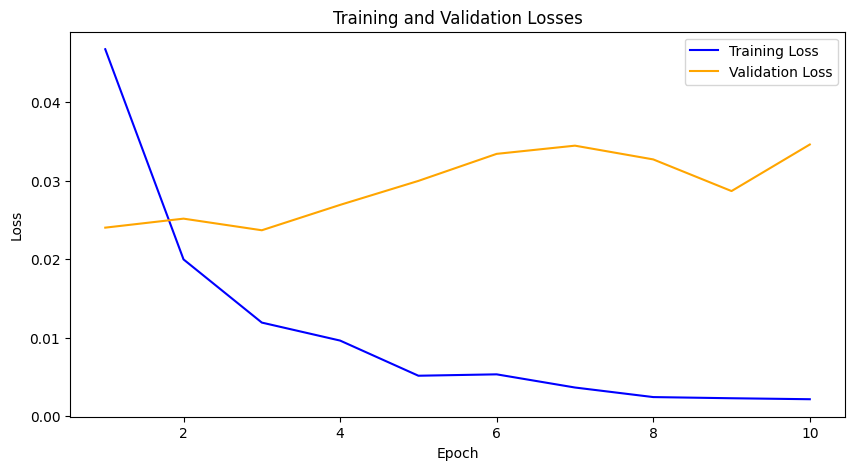

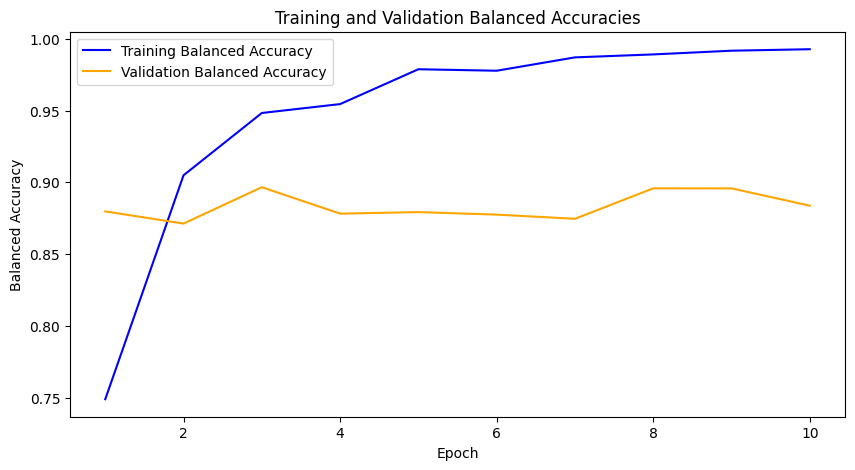

In [104]:
train(model, df_under_aug_train, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

In [105]:
EPOCHS = 3
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'combined'

In [106]:
df_trainval.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,517,517,517,517,517,517
Drugs and Narcotics Trade,405,405,405,405,405,405
Financial Crime,656,656,656,656,656,656
Violent Crime,45,45,45,45,45,45
Weapons Trade,87,87,87,87,87,87


In [33]:
under_mix_trainval = RandomUnderSampler(sampling_strategy={'Financial Crime':517, "Cybercrime":517, "Drugs and Narcotics Trade":405, "Weapons Trade":87, "Violent Crime":45}, random_state=42) 
df_under_mix_trainval, _ = under_mix_trainval.fit_resample(df_trainval, df_trainval[["label"]])
df_under_mix_trainval.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,517,517,517,517,517,517
Drugs and Narcotics Trade,405,405,405,405,405,405
Financial Crime,517,517,517,517,517,517
Violent Crime,45,45,45,45,45,45
Weapons Trade,87,87,87,87,87,87


In [34]:
df_under_aug_trainval = pd.concat([df_under_mix_trainval[['text', 'label']], df_aug_drugs_trade_train_quant2.sample(n=112, random_state=42), df_aug_violent_crime_train_quant2.sample(n=472, random_state=42), df_aug_weapons_trade_train_quant2.sample(n=430, random_state=42)], ignore_index=True)

df_under_aug_trainval['text'] = df_under_aug_trainval['text'].apply(lambda x: x.lower()) 
df_under_aug_trainval.groupby('label').count()

,text
label,
Cybercrime,517
Drugs and Narcotics Trade,517
Financial Crime,517
Violent Crime,517
Weapons Trade,517


In [109]:
train(model, df_under_aug_trainval, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/162 [00:00<?, ?it/s]

100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Balanced Accuracy: 0.91161
F1 Score: 0.89747

Financial Crime Recall: 0.92683

Cybercrime Recall: 0.89147

Drugs and Narcotics Trade Recall: 0.92157

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.90909



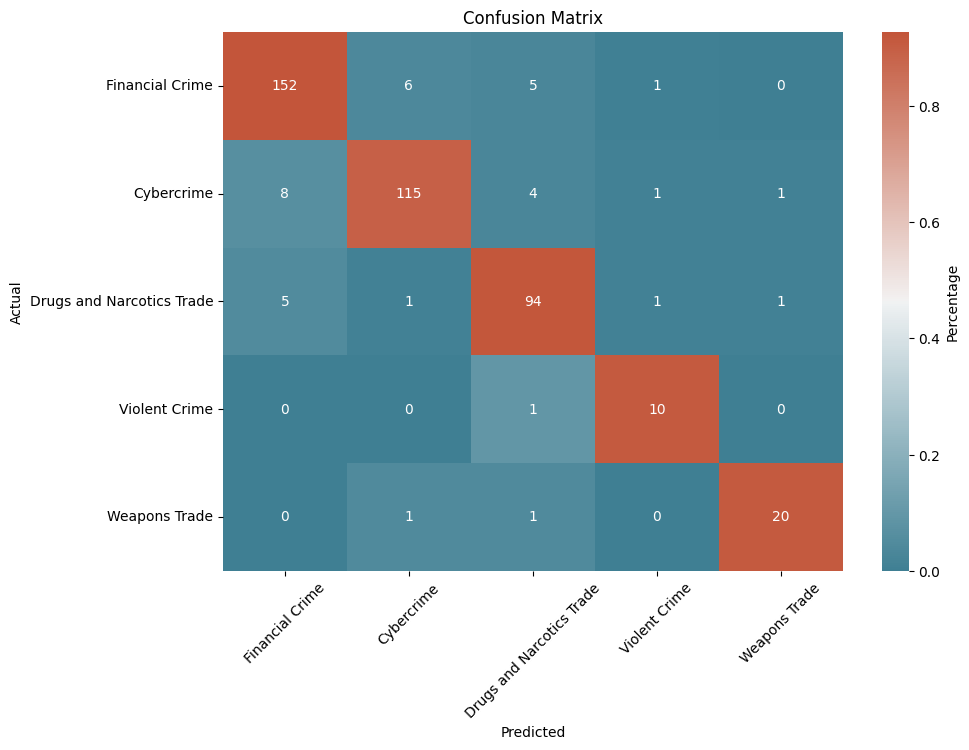

In [110]:
evaluate(model, df_test, mode=mode, metrics=True, save_pred = True)